In [25]:
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [ ]:
# Paths
model_path = "adaptive_efficientnetv2_rw_s_emotion_model.pth"
data_dir = "../DATA_PREPARE_ATT_04/Grayscale_Face_images"

In [6]:
# Configuration
batch_size = 32
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Emotion categories
emotion_classes = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

Using device: cuda


In [ ]:
# Data Preparation for Testing
def prepare_test_loader(data_dir, batch_size):
    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    print("Loading test dataset...")
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    print("Test dataset loaded.")
    return test_loader, test_dataset

In [8]:
# Load Model
def load_model(model_path, num_classes):
    print("Loading the saved model...")
    model = create_model('efficientnetv2_rw_s', pretrained=True, num_classes=num_classes, in_chans=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    print("Model loaded successfully.")
    return model

In [9]:
# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def plot_sample_predictions_per_class(model, data_dir, classes, samples_per_class=5):
    model.eval()
    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    # Prepare grid plot
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 3, len(classes) * 3))
    fig.suptitle("Sample Predictions (5 per Class)", fontsize=16, y=0.92)
    
    for class_idx, emotion in enumerate(classes):
        folder_path = os.path.join(data_dir, emotion)
        image_files = os.listdir(folder_path)
        selected_files = random.sample(image_files, samples_per_class)
        
        for i, file_name in enumerate(selected_files):
            img_path = os.path.join(folder_path, file_name)
            img = Image.open(img_path).convert("L")  
            input_tensor = transform_test(img).unsqueeze(0).to(device) 
            
            # Get prediction
            with torch.no_grad():
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
                pred_label = classes[predicted.item()]
            
            # Display the image
            ax = axes[class_idx, i]
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            # Set the true and predicted labels
            ax.set_title(f"True: {emotion}\nPred: {pred_label}", fontsize=8, pad=10)
        
        # Add emotion label on the leftmost column
        axes[class_idx, 0].set_ylabel(emotion, rotation=90, size='large', labelpad=20)

    plt.tight_layout()
    plt.show()

In [21]:
# Evaluate Model with Loss and Accuracy Plots
def evaluate_model_with_plots(model, test_loader, classes):
    print("\nEvaluating on Test Data...")
    model.eval()
    test_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    batch_losses, batch_accuracies = [], []
    criterion = nn.CrossEntropyLoss()

    with tqdm(total=len(test_loader), desc="Testing Batches", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Batch-level metrics
                batch_losses.append(loss.item())
                batch_accuracies.append((predicted == labels).sum().item() / labels.size(0))

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.update(1)

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Plotting loss and accuracy per batch
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(batch_losses, label="Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch-wise Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(batch_accuracies, label="Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.title("Batch-wise Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    plot_confusion_matrix(conf_matrix, classes)

    return test_accuracy, test_loss, conf_matrix

Loading test dataset...
Test dataset loaded.
Loading the saved model...


C:\Users\Tuf\AppData\Local\Temp\ipykernel_25324\2997424614.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Model loaded successfully.

Evaluating on Test Data...


Testing Batches: 100%|██████████| 604/604 [02:14<00:00,  4.50batch/s]


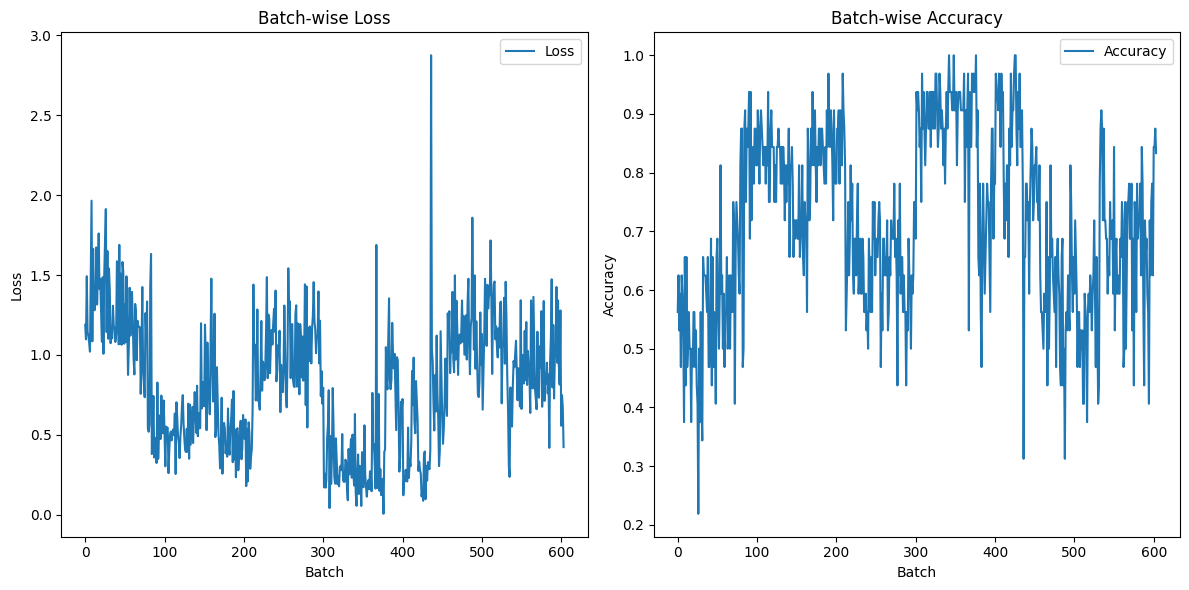


Test Loss: 0.8178, Test Accuracy: 71.65%

Classification Report:
              precision    recall  f1-score   support

       Anger       0.63      0.54      0.59      2361
    Contempt       0.83      0.80      0.81      2552
     Disgust       0.72      0.79      0.75      2423
        Fear       0.58      0.63      0.60      2281
       Happy       0.88      0.90      0.89      2508
     Neutral       0.74      0.79      0.76      2507
         Sad       0.58      0.57      0.58      2253
    Surprise       0.74      0.68      0.71      2417

    accuracy                           0.72     19302
   macro avg       0.71      0.71      0.71     19302
weighted avg       0.72      0.72      0.72     19302


Confusion Matrix:
[[1285   96  289  206   44  117  252   72]
 [ 100 2035  173   33    5   50   91   65]
 [ 126   74 1903  102   11   23  125   59]
 [ 138   42   84 1437   41   93  224  222]
 [  18   13    2   11 2259  143   24   38]
 [  94   34   26   61  128 1980  143   41]
 [ 220

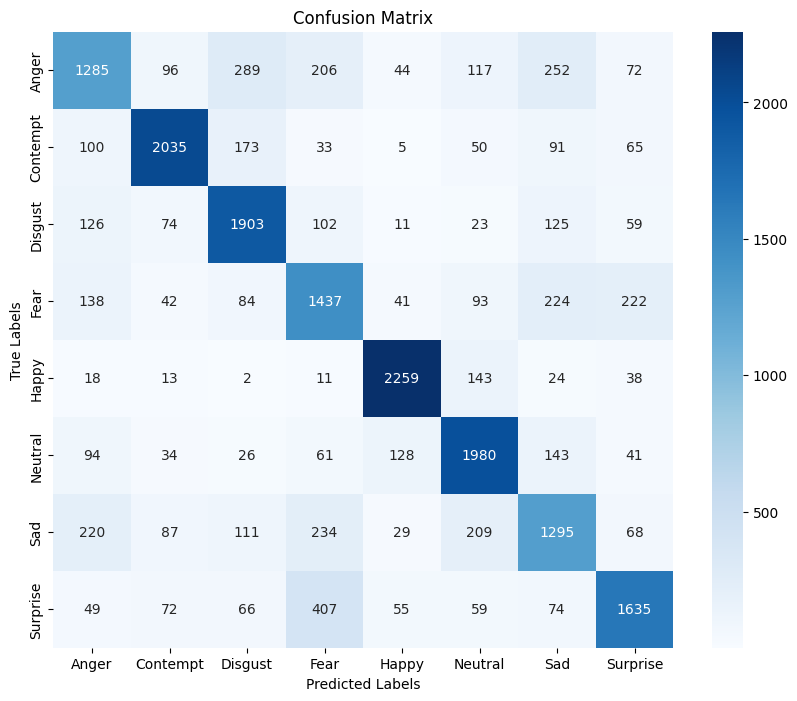

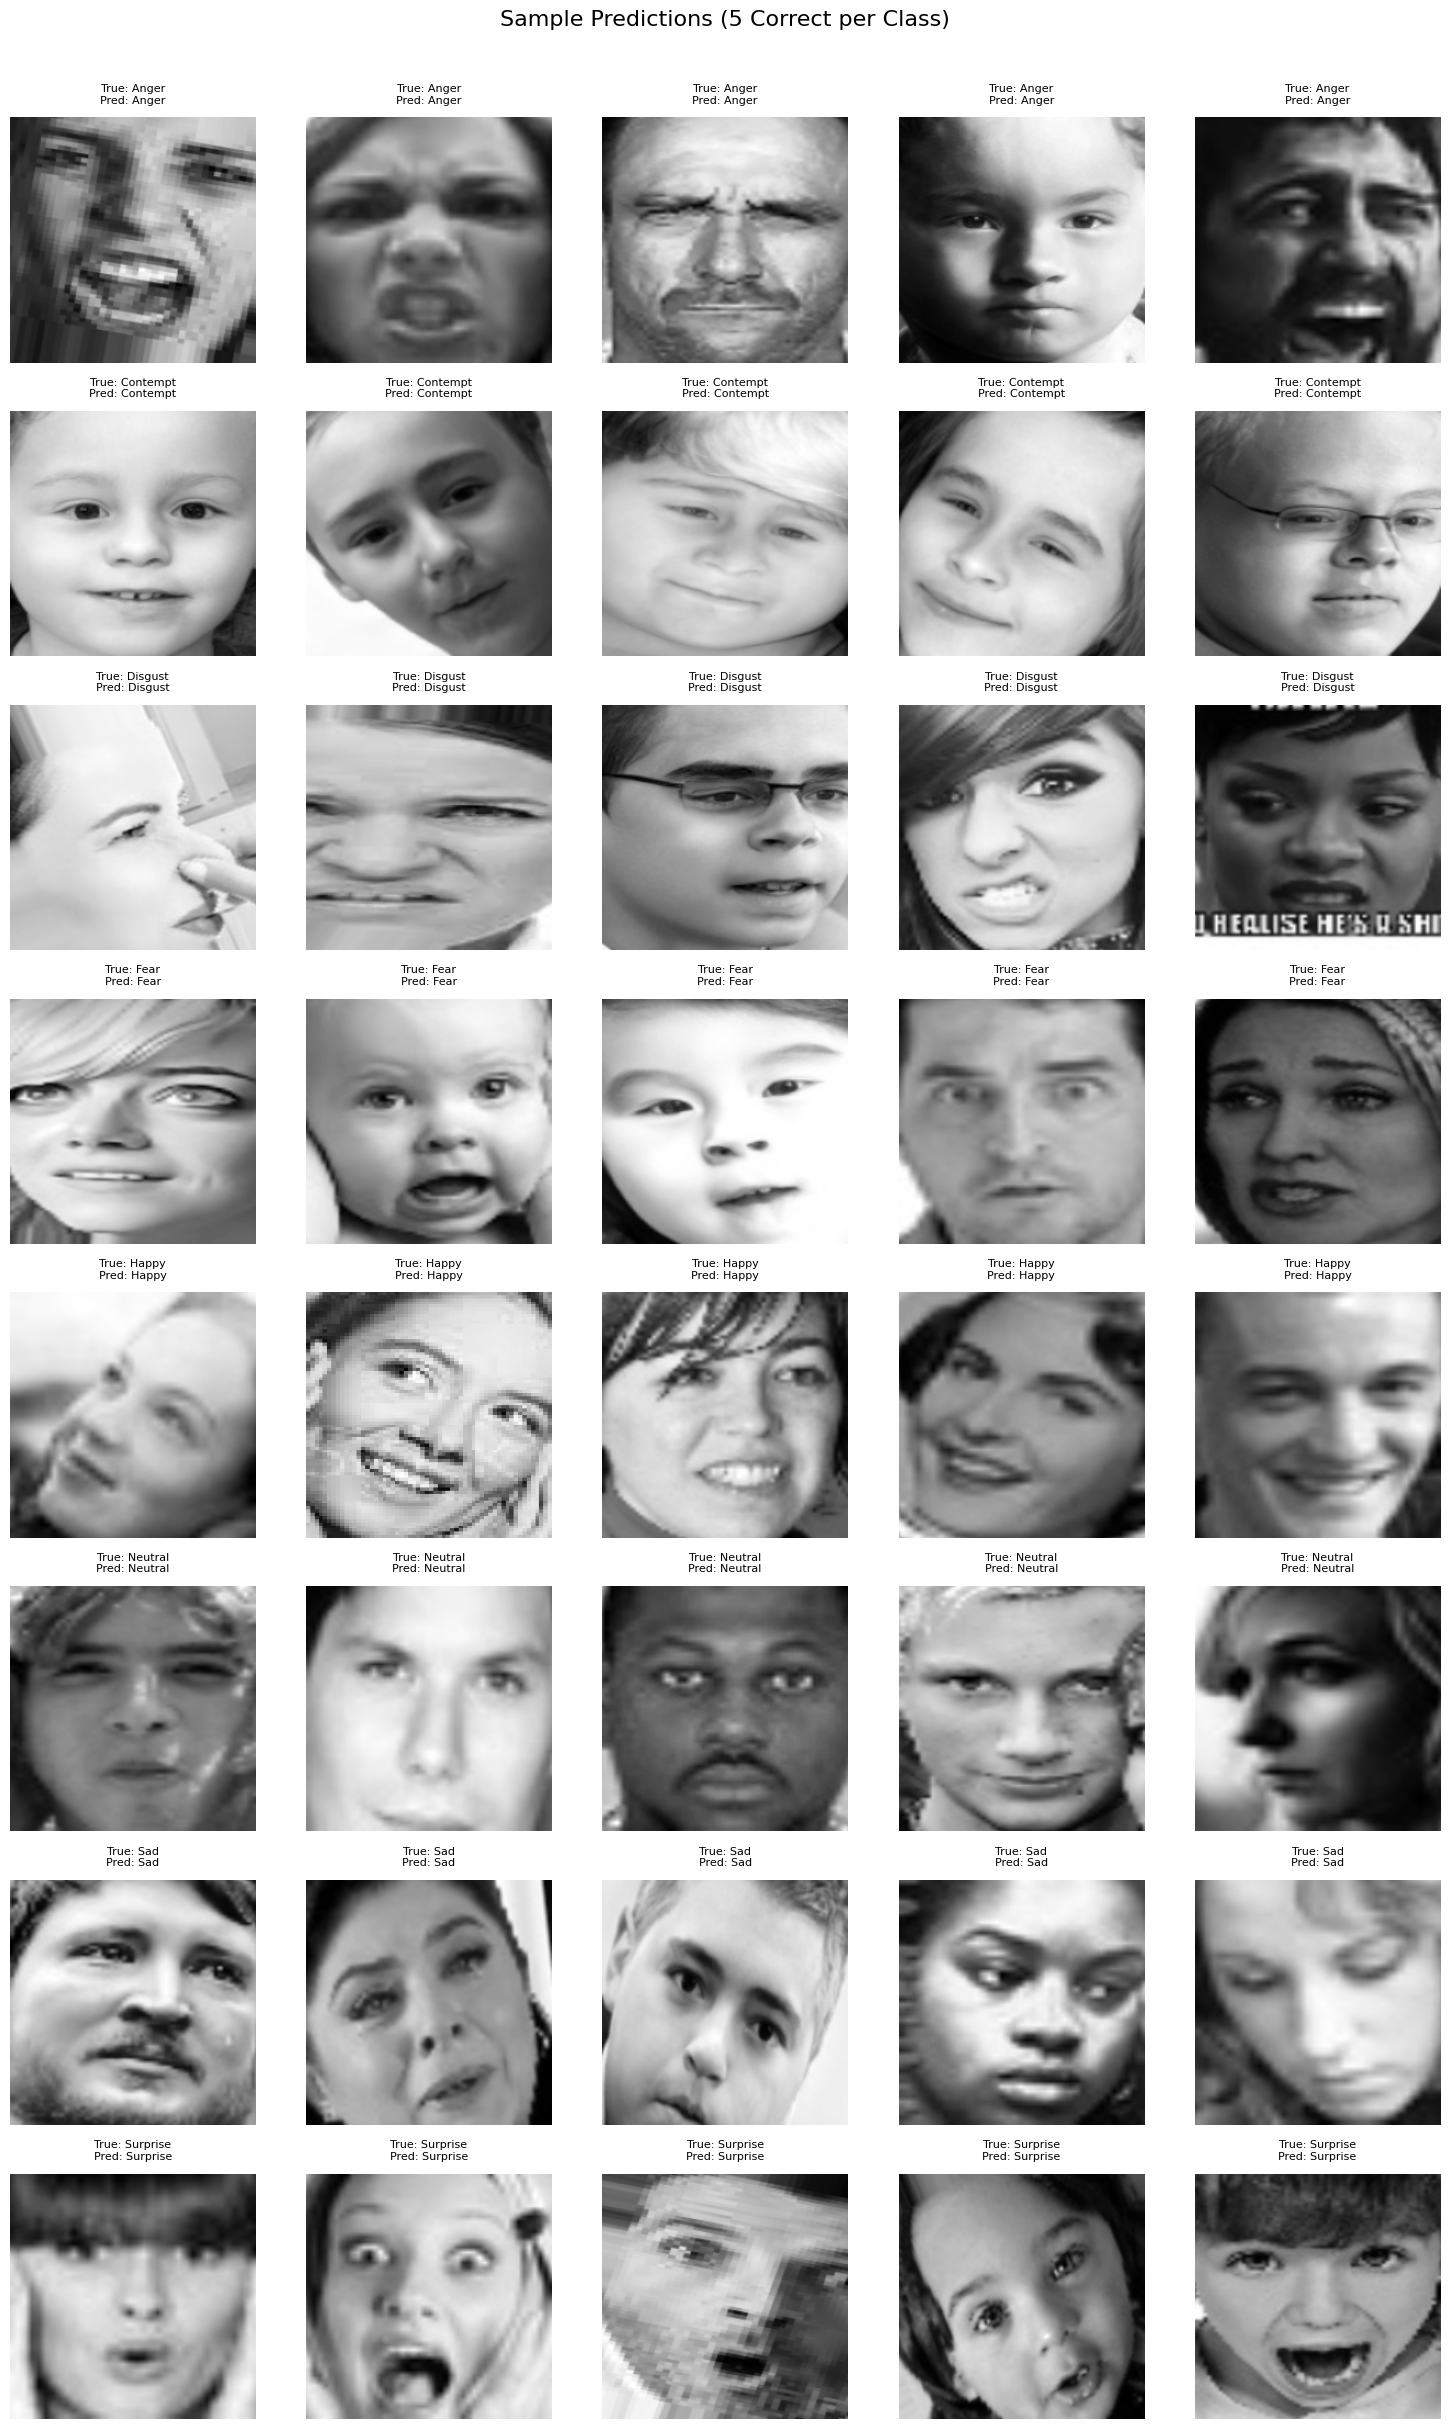

In [40]:
# Main Script
if __name__ == "__main__":
    test_loader, test_dataset = prepare_test_loader(data_dir, batch_size)
    model = load_model(model_path, num_classes)
    evaluate_model_with_plots(model, test_loader, emotion_classes)
    plot_sample_predictions_per_class(model, os.path.join(data_dir, "test"), emotion_classes, samples_per_class=5)